# Model Evaluation

## Import Modules

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

## RunParameters Class

In [2]:
class RunParameters:
    '''classe che gestisce i parametri della run'''
    
    def __init__(self, out_dir: str, ndir=0, ntoy=40, magic=0):
        '''init: imposto il nome della cartella di output, genero il nome della cartella contenente il file e cerco il file'''
        
        self.out_dir = out_dir
        self.folder_name = os.listdir(self.out_dir+f'/{magic}/')[ndir]
        self.fname = [name for name in os.listdir(self.out_dir+f'/{magic}/'+self.folder_name) if f'_toy{ntoy}_t.txt' in name][0]
        
        return
    
    def fetch_parameters(self) -> list:
        '''uso il nome del file e della cartella per estrarre i parametri della run'''
        
        self.check_point_t = int(self.fname.split("patience", 1)[1].split("_", 1)[0])
        self.toys = int(self.fname.split("toy", 1)[1].split("_", 1)[0])
        self.ref = (self.fname.split("_")[2]).split("ref")[1]
        self.bkg = (self.fname.split("_")[3]).split("bkg")[1]
        self.sig = (self.fname.split("_")[4]).split("sig")[1]
        self.w_clip = self.folder_name.split('wclip',1)[1]
        self.latent = int(self.folder_name.split("latent", 1)[1].split("_", 1)[0])
        self.layers = int(self.folder_name.split("layers", 1)[1].split("_", 1)[0])
        self.epochs = int(self.folder_name.split('epochs',1)[1].split('_')[0])
        
        self.parameters = [self.toys, self.w_clip, self.epochs, self.check_point_t, self.ref, self.bkg, self.sig, self.latent, self.layers]
        
        return self.parameters
    
    def print_parameters(self):
        '''stampo i parametri per controllare corrispondano alla run'''
        
        print('\nFolder name: ' + self.folder_name)
        print('File name: ' + self.fname)
        
        print(f'\nParameters:                                              \
                        \n Toys:          {self.toys}                      \
                        \n Latent space:  {self.latent}                    \
                        \n Layers:        {self.layers}                    \
                        \n W_clip:        {self.w_clip}                    \
                        \n Epochs:        {self.epochs}                    \
                        \n Check_point_t: {self.check_point_t}             \
                        \n Ref, Bkg, Sig: {self.ref} {self.bkg} {self.sig} \n'
             )
        
        return  
    
    def fetch_file(self) -> str:
        '''genero il nome completo del file contenente il t finale'''
        
        self.tfile = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_t.txt'
        
        self.tfile = self.tfile.replace(' ', '')
        
        return self.tfile
    
    def fetch_history(self) -> str:
        '''genero il nome completo del file contenente il t per ogni checkpoint'''
        
        self.thistory = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_history{self.check_point_t}.h5'
        
        self.thistory = self.thistory.replace(' ', '')
        
        return self.thistory

## T Distribution Class

In [44]:
class TDist:
    '''classe che gestisce la distribuzione dei t'''
    
    def __init__(self, dof, bins, toys, epochs, check_point_t, out_dir, tfile, thistory):
        '''init: imposto parametri importanti della run e i file di interesse'''
        
        self.dof = dof
        self.bins = bins
        self.epochs = epochs
        self.check_point_t = check_point_t
        self.toys = toys
        self.OUT_PATH = out_dir
        self.OUT_FILE_t = tfile
        self.OUT_FILE_t_history = thistory
        
        return
    
    
    def plotOutPath(self):
        path = '/lustre/cmswork/nlai/PLOTS/MODEL_SELECTION/'
        rPar = RunParameters(self.OUT_PATH, 0, self.toys)
        toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
        
        pngfile = f'1D_patience{check_point_t}_ref{ref}_bkg{bkg}_sig{sig}\
        _epochs{epochs}_latent{latent}_layers{layers}_wclip{w_clip}_toy{toys}'
        
        pngfile = pngfile.replace(' ', '')
        
        self.pngpath = path + pngfile
        
        return self.pngpath
    
    
    def getT(self):
        '''ciclo su tutti i file per prendere tutti i t e tutte le history'''
        
        self.t_list=[]
        self.t_list_history=[]
        counter=0
        preview=0
        for i in range(self.toys-preview):
            
            file_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t
            if os.path.isfile(file_name):
                f = open(file_name, "r")
                self.t_list.append(float(f.readline()[:-1]))
                f.close()
                #print(i)
                if np.logical_not(np.isnan(self.t_list[-1])):
                    counter += 1
                    
            history_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t_history
            if os.path.isfile(history_name):
                f = h5py.File(history_name, "r")
                try:
                    self.t_list_history.append(-2*np.array(f.get('loss')))
                except: print('Problem with toy ', i)
                f.close()
                
        self.t_list=np.array(self.t_list)
        self.t_list_history=np.array(self.t_list_history)
        
        print(f"\nToys at disposal/Total toys: {counter}/{self.toys-preview}")
        
        return 
    
    
    def computeMedian(self):
        '''calcolo la mediana per un rapido controllo di compatibilità'''
        
        median_t = np.median(self.t_list)
        print("\nMedian t distribution: ", median_t)
        
        p_list = np.sum([1/(len(self.t_list)) for x in self.t_list if x>median_t])
        
        print(
            f"Median p-value: {p_list :.4f}\
            Median significance: {scipy.stats.norm.ppf(1-p_list):.4f}\
            from t list"
        )
        
        print(
            f"Median p-value: {scipy.stats.chi2.sf(median_t, df=self.dof):.4f}\
            Median significance: {scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(median_t, df=self.dof)):.4f}\
            from chi2 distribution" 
        ) 
        
        return
    
    
    def change_legend(self, ax, new_loc, fontsize, titlesize, **kws):
        '''funzione per modificare posizione e font size della legenda generata da seaborn'''

        old_legend = ax.legend_
        handles = old_legend.legendHandles
        labels = [t.get_text() for t in old_legend.get_texts()]
        title = old_legend.get_title().get_text()

        ax.legend(handles, labels, loc=new_loc, title=title, fontsize=fontsize, title_fontsize=titlesize, frameon = True, fancybox = False, framealpha = 0.5, **kws)
    
        return
    
    
    def plotTdist(self, train_dist):
        '''grafico della distribuzione dei t'''
        
        XMIN = 0
        if max(self.t_list) >= 3*self.dof:
            XMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            XMAX = 3*self.dof
            
        YMIN = 0
        YMAX = 1
            
        XGRID = np.linspace(XMIN, XMAX, 500)
        BINS = self.bins
        
        self.tobs_pval = scipy.stats.chi2.sf(self.t_list[-1], df=self.dof)
        self.tobs_sig = scipy.stats.norm.ppf(1-self.tobs_pval)
        
#         fit_par = scipy.stats.chi2.fit(self.t_list, floc=0, fscale=1)
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        ax.axvline(x=self.t_list[-1], 
                   color='red', linestyle='solid', linewidth=5, alpha=0.6, 
                   label=f'tOBS: {self.t_list[-1]}')
        
        ax = sns.histplot(x=train_dist, bins=BINS, 
                          stat='density', element='bars', fill=True, color='#aadeff', edgecolor='#009cff', 
                          label='reference t distribution')
        
        hist, bin_edges = np.histogram(train_dist, density=True, bins=BINS)
        binswidth = bin_edges[1]-bin_edges[0]
        central_points = []
        for i in range(0, len(bin_edges)-1):
            half = (bin_edges[i] + bin_edges[i+1])/2
            central_points.append(half)
            
        err = np.sqrt(hist/(train_dist.shape[0]*binswidth))
    
        ax.errorbar(central_points, hist, yerr = err, color='#009cff', marker='o', ls='')
        
        ax.plot(XGRID,scipy.stats.chi2.pdf(XGRID, df=self.dof), 
                color='#009cff', linestyle='solid', linewidth=5, alpha=0.6, 
                label=f'theoretical t distribution, dof: {self.dof}')
        
        ax.text(x=0.65,y=0.65,s=( 'tOBS p-value = ' + format(self.tobs_pval,'1.5f') + '\ntOBS significance = ' + format(self.tobs_sig,'1.2f') + '\u03C3' ),
                fontsize=14, color='black', fontvariant='small-caps', transform=ax.transAxes)
        
        
        ax.set_title('tOBS with reference t distribution', fontsize = 18)
        ax.set_xlabel('t', fontsize = 16)
        ax.set_ylabel('density', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)

        ax.set_xlim(XMIN, XMAX)
        ax.set_ylim(bottom=YMIN)
        
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[idx] for idx in [2, 1, 0]], [labels[idx] for idx in [2, 1, 0]])
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tdist_predict.png', dpi = 300, facecolor='white')
        plt.show()
        
        print('tOBS p-value = ' + format(self.tobs_pval,'1.5f'))
        print('tOBS significance = ' + format(self.tobs_sig,'1.5f'))
        
        return 
    
    
    def plotThistory(self):
        '''grafico della storia dei t'''
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.t_list) >= 3*self.dof:
            YMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            YMAX = 3*self.dof
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        for i in range(len(self.t_list_history)):
            ax.plot(x_tics[1:],self.t_list_history[i][1:])
            
        ax.set_title('t history', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('t', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        ax.set_xlim(XMIN, XMAX)
        ax.set_ylim(YMIN, YMAX)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_thistory_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotQuantilesEvo(self):
        '''grafico dell'evoluzione dei quantili della distribuzione dei t'''
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.t_list) >= 3*self.dof:
            YMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            YMAX = 3*self.dof
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        quantile_list = [0.05,0.25,0.50,0.75,0.95]
        color_list = ['#ff0000', '#00ff00', '#0080ff', '#ff8000', '#ff00ff']
        th_quantile_position = [scipy.stats.chi2.ppf(i,df=self.dof) for i in quantile_list]
        t_quantile = np.quantile(self.t_list_history, quantile_list, axis=0)
        
        for i in range(len(quantile_list)):
            ax.plot(x_tics[1:], t_quantile[i][1:], 
                    color = color_list[i], linestyle='solid', linewidth = 3, 
                    label = format(quantile_list[i], '1.2f'))
            ax.plot(x_tics[-1], th_quantile_position[i], marker='X', markersize = 15,
                    color = color_list[i])
            ax.hlines(y=th_quantile_position[i], xmin = XMIN, xmax = XMAX, 
                      color = color_list[i], linestyle='dashed', linewidth = 3, alpha = 0.5, 
                    label = 'theoretical ' + format(quantile_list[i], '1.2f'))
        ax.set_title('t quantiles evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('t', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        ax.set_xlim(XMIN, XMAX)
        ax.set_ylim(YMIN, YMAX)
        
        ax.legend(title = 'Quantiles', ncol = 2)
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        ax.legend(title = 'Quantiles', ncol = 2)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tquantiles_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotChi2History(self):
        self.t_chi2_history = []
        bin_number = self.bins # ???????????????????? cambiare bin cambia tanto (daniele 20)
        
        for counter in range(10, self.t_list_history.shape[1]): 
            # binning della distribuzione dei t per ogni checkpoint
            t_hist, binedges = np.histogram(self.t_list_history[:, counter], bins=bin_number, density=True) 
            # cerco il centro di ciascun bin
            bincenter = np.array([(binedges[i+1]+binedges[i])/2 for i in range(len(t_hist))])
            # calcolo l'altezza teorica di ciascun bin
            th_bins = np.array([scipy.stats.chi2.pdf(b_center, df=self.dof) for b_center in bincenter])
            # calcolo il chi2
            self.t_chi2_history.append(np.sum((t_hist-th_bins)**2/th_bins,axis=0)) #(toys-preview)*
    
        XMIN = 0
        XMAX = self.epochs

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0][10:]
        
        ax.plot(x_tics[:], self.t_chi2_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'chi2 final value: {self.t_chi2_history[-1]:.3f}')
        
        ax.set_title('chi2 evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('chi2', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        ax.set_yscale('log')
        
        ax.set_xlim(XMIN, XMAX)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tchi2_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        
        return
    
    
#     def plotChi2Compatibility(self):
#         self.t_chi2_compatibility = []
#         bin_number = self.bins # ???????????????????? cambiare bin cambia tanto (daniele 20)
        
#         for counter in range(10, self.t_list_history.shape[1]): 
#             # binning della distribuzione dei t per ogni checkpoint
#             t_hist, binedges = np.histogram(self.t_list_history[:, counter], bins=bin_number, density=True) 
#             # cerco il centro di ciascun bin
#             bincenter = np.array([(binedges[i+1]+binedges[i])/2 for i in range(len(t_hist))])
#             # calcolo l'altezza teorica di ciascun bin
#             th_bins = np.array([scipy.stats.chi2.pdf(b_center, df=self.dof) for b_center in bincenter])
#             # calcolo il chi2
#             self.t_chi2_compatibility.append(np.sum((t_hist-th_bins)**2/th_bins,axis=0))
    
#         XMIN = 0
#         XMAX = self.epochs

#         fig, ax = plt.subplots(figsize=(12,7))

#         x_tics = np.array(range(self.epochs))
#         x_tics = x_tics[x_tics % check_point_t == 0][10:]
        
#         ax.plot(x_tics[:], self.t_chi2_compatibility[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
# #                 label=f'lambda final value: {self.t_chi2_compatibility[-1]:.3f}'
#                )
        
#         ax.set_title('compatibility evolution', fontsize = 18)
#         ax.set_xlabel('training epoch', fontsize = 16)
#         ax.set_ylabel('lambda', fontsize = 16)
#         ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
#         ax.set_yscale('log')
        
#         ax.set_xlim(XMIN, XMAX)
        
#         ax.legend()
#         self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
#         fig.tight_layout()
        
#         plt.show()
        
#         return
    
    
    def plotPValHistory(self):
        
        bin_number = self.bins
        self.pvalue_history=scipy.stats.chi2.sf(self.t_chi2_history[:], df=bin_number-1) # 20-1????????

        XMIN = 0
        XMAX = self.epochs
        YMIN = 0
        YMAX = 1.2

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0][10:]
        y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[:], self.pvalue_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'p-val final value: {self.pvalue_history[-1]:.3f}')
        
        ax.set_title('p-value evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('p-value', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        ax.set_yticks(y_tics)
        
        ax.set_xlim(XMIN, XMAX)
        ax.set_ylim(YMIN, YMAX)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tpval_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        
        return

    
    def plotSignificanceHistory(self):
        
        bin_number = self.bins
        self.significance_history=scipy.stats.norm.ppf(1-self.pvalue_history[:])

        XMIN = 0
        XMAX = self.epochs
#         YMIN = 0
#         YMAX = max(self.significance_history)+min(self.significance_history)

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0][10:]
#         y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[:], self.significance_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'significance final value: {self.significance_history[-1]:.3f}')
        
        ax.set_title('significance evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('significance', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
#         ax.set_yticks(y_tics)
        
        ax.set_xlim(XMIN, XMAX)
#         ax.set_ylim(YMIN, YMAX)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tpval_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        
        return
    
    
    def plotSignificanceToyhistory(self):
        '''grafico della storia della significanza per ogni toy'''
        
        XMIN = 0
        XMAX = self.epochs
        
#         YMIN = 0
#         if max(self.t_list) >= 3*self.dof:
#             YMAX = max(self.t_list) + min(self.t_list) 
#         elif max(self.t_list) < 3*self.dof:
#             YMAX = 3*self.dof
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        for i in range(len(self.t_list_history)):
            ax.plot(x_tics[1:],scipy.stats.norm.ppf(1.0-scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof)))
            # pvalue
            print('Pval')
            print( np.array( scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof ), dtype=np.float128 ) )
            print('Pval - cdf')
            print(scipy.stats.chi2.cdf(self.t_list_history[i][1:], df=self.dof))
            print('Differenza')
            print(  scipy.stats.norm.ppf(np.ones( len(self.t_list_history[i][1:]), dtype=np.float128 ) - np.array(scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof), dtype=np.float128) ))
            print('Significance')
            print(scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof)))
            
        ax.set_title('significance history per toy', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('significance', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        ax.set_xlim(XMIN, XMAX)
#         ax.set_ylim(YMIN, YMAX)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_thistory_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotSignificanceToyDistribution(self):
        '''grafico della storia della significanza per ogni toy'''

        self.significance_dist = scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(self.t_list[:], df=self.dof))

        fig, ax = plt.subplots(figsize=(12,7))
        
        ax = sns.histplot(x=self.significance_dist, bins=self.bins, 
                          stat='density', element='bars', fill=True, color='#aadeff', edgecolor='#009cff', 
                          label='significance distribution')
            
        ax.set_title('significance distribution', fontsize = 18)
        ax.set_xlabel('significance', fontsize = 16)
        ax.set_ylabel('density', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)

        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_thistory_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    

def getTtrain():
    WCLIP = 7
    NTOYS = 150
    EPOCHS = '200k'
    JOB = 'hstat' # 'hstat'
    TOY_TEST = 0
    OUT_PATH = f'E{EPOCHS}W{WCLIP}_{JOB}'
    DOF = 10
    NFOLDER = 0
    
    rPar = RunParameters(OUT_PATH, NFOLDER, NTOYS, TOY_TEST)
    toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
#     rPar.print_parameters()

    OUT_FILE_t = rPar.fetch_file()
    OUT_FILE_t_history = rPar.fetch_history()
    tTrain = TDist(DOF, BINS, toys, epochs, check_point_t, OUT_PATH, OUT_FILE_t, OUT_FILE_t_history)
    tTrain.getT()
    return tTrain.t_list

## Check Run Parameters

In [45]:
WCLIP = 7 # MODIFY THIS FOR CHANGING DIRECTORY
NTOYS = 1

EPOCHS = '100k'
SIGNAL = 50
JOB = 'predict' # 'hstat'
TOY_TEST = 0

OUT_PATH = f'E{EPOCHS}W{WCLIP}s{SIGNAL}_{JOB}'
DOF = 10
NFOLDER = 0

rPar = RunParameters(OUT_PATH, NFOLDER, NTOYS, TOY_TEST)
toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
rPar.print_parameters()

OUT_FILE_t = rPar.fetch_file()
OUT_FILE_t_history = rPar.fetch_history()


Folder name: 1D_patience1000_ref100000_bkg10000_sig50_epochs100000_latent3_layers1_wclip7.0
File name: 1D_patience1000_ref100000_bkg10000_sig50_toy1_t.txt

Parameters:                                                                      
 Toys:          1                                              
 Latent space:  3                                            
 Layers:        1                                            
 W_clip:        7.0                                            
 Epochs:        100000                                            
 Check_point_t: 1000                                     
 Ref, Bkg, Sig: 100000 10000 50 



## Model Analysis


Toys at disposal/Total toys: 1/1

Median t distribution:  207.950287
Median p-value: 0.0000            Median significance: inf            from t list
Median p-value: 0.0000            Median significance: inf            from chi2 distribution

Toys at disposal/Total toys: 150/150


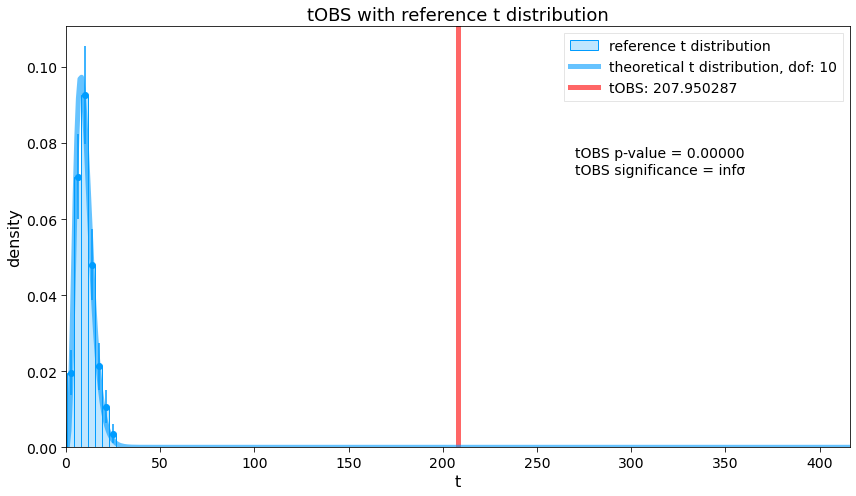

tOBS p-value = 0.00000
tOBS significance = inf


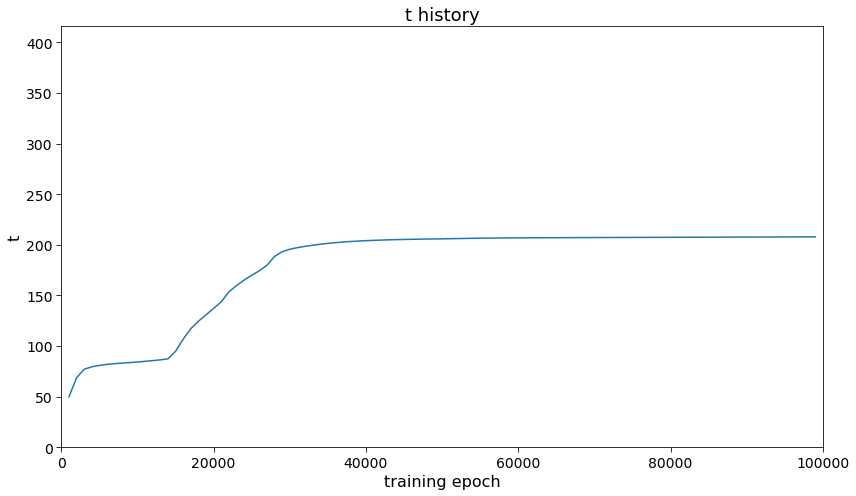

Pval
[2.83130960e-07 7.84051166e-11 1.85651441e-12 6.17418753e-13
 3.27710859e-13 2.09776603e-13 1.52936608e-13 1.18886753e-13
 9.40171665e-14 7.18594389e-14 5.25965157e-14 3.85295073e-14
 2.75309871e-14 1.73066098e-14 5.79273442e-16 2.23583639e-18
 1.89010389e-20 5.87928246e-22 3.01086609e-23 1.52415373e-24
 7.19306907e-26 6.63115935e-28 3.59435976e-29 2.71573265e-30
 2.71986535e-31 3.41406341e-32 2.48089639e-33 3.78512848e-35
 4.01201924e-36 1.25829092e-36 5.88212210e-37 3.19812401e-37
 1.87547763e-37 1.17359693e-37 7.82763966e-38 5.54268798e-38
 4.13538959e-38 3.21660053e-38 2.60186899e-38 2.17680453e-38
 1.86592264e-38 1.63560595e-38 1.46086110e-38 1.32551853e-38
 1.21886521e-38 1.13286633e-38 1.06322479e-38 1.00389066e-38
 9.54957563e-39 9.10229849e-39 8.59323486e-39 8.02661158e-39
 7.52803692e-39 7.10886330e-39 6.76468813e-39 6.47359214e-39
 6.22801376e-39 6.02768499e-39 5.85824706e-39 5.71495774e-39
 5.60100321e-39 5.48851453e-39 5.39619082e-39 5.32031124e-39
 5.24103536e-39 5.1

TypeError: ufunc 'ndtri' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

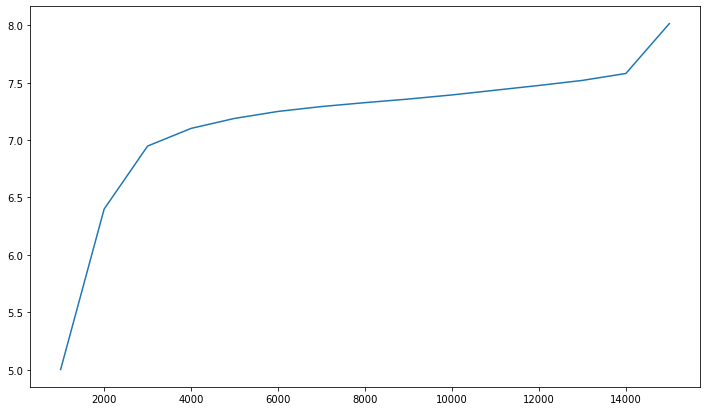

In [46]:
BINS = 7

tDist = TDist(DOF, BINS, toys, epochs, check_point_t, OUT_PATH, OUT_FILE_t, OUT_FILE_t_history)
tDist.getT()
tDist.computeMedian()

tDist.plotTdist(getTtrain())
tDist.plotThistory()
# tDist.plotQuantilesEvo()
# tDist.plotChi2History()
# tDist.plotChi2Compatibility()
# tDist.plotPValHistory()
# tDist.plotSignificanceHistory()
tDist.plotSignificanceToyhistory()
# tDist.plotSignificanceToyDistribution()